In [1]:
import xarray as xr
import os
import glob
import pickle
import pandas as pd
import numpy as np
import scipy.stats
from turtle import width
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import transform
from minisom import MiniSom
from scipy.spatial import distance
from cnmaps import get_map, draw_map, clip_contours_by_map
import proplot as pplt

import matplotlib.pyplot as plt
import cmaps

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

os.chdir('/Users/zeqinhuang/Documents/paper/anomalous_PREC')

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
models = [
    'ACCESS-CM2','ACCESS-ESM1-5','BCC-CSM2-MR','CESM2-WACCM','CESM2','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','CanESM5',
    'EC-Earth3-Veg-LR','EC-Earth3','FGOALS-g3','GFDL-CM4','GFDL-CM4_gr2','GFDL-ESM4','GISS-E2-1-G','HadGEM3-GC31-LL','HadGEM3-GC31-MM',
    'IITM-ESM','INM-CM4-8','INM-CM5-0','IPSL-CM6A-LR','KACE-1-0-G','KIOST-ESM','MIROC-ES2L','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR',
    'MRI-ESM2-0','NESM3','NorESM2-LM','NorESM2-MM','TaiESM1','UKESM1-0-LL']


In [3]:
som_weight_patterns = pd.read_csv('output/som_weight_patterns_obs.csv',index_col=0)

som_weight_pattern1 = som_weight_patterns['pattern1']
som_weight_pattern2 = som_weight_patterns['pattern2']
som_weight_pattern3 = som_weight_patterns['pattern3']
som_weight_pattern4 = som_weight_patterns['pattern4']
som_weight_pattern5 = som_weight_patterns['pattern5']
som_weight_pattern6 = som_weight_patterns['pattern6']

In [4]:
def determine_winner(prec_ano_data):
    winners = []

    data_stack = prec_ano_data.stack(z=('lon','lat'))
    data_stack_del_nan = data_stack.loc[:,data_stack['z'][~np.isnan(data_stack[0,:])]] ##### delete nan values
    data_stack = data_stack_del_nan.values
   
    for i in range(len(data_stack)):
        corr1 = scipy.stats.pearsonr(data_stack[i],som_weight_pattern1)
        corr2 = scipy.stats.pearsonr(data_stack[i],som_weight_pattern2)
        corr3 = scipy.stats.pearsonr(data_stack[i],som_weight_pattern3)
        corr4 = scipy.stats.pearsonr(data_stack[i],som_weight_pattern4)
        corr5 = scipy.stats.pearsonr(data_stack[i],som_weight_pattern5)
        corr6 = scipy.stats.pearsonr(data_stack[i],som_weight_pattern6)
        dist1 = distance.euclidean(data_stack[i],som_weight_pattern1)
        dist2 = distance.euclidean(data_stack[i],som_weight_pattern2)
        dist3 = distance.euclidean(data_stack[i],som_weight_pattern3)
        dist4 = distance.euclidean(data_stack[i],som_weight_pattern4)
        dist5 = distance.euclidean(data_stack[i],som_weight_pattern5)
        dist6 = distance.euclidean(data_stack[i],som_weight_pattern6)
        
        dists = np.array([corr1[0]/dist1,corr2[0]/dist2,corr3[0]/dist3,corr4[0]/dist4,corr5[0]/dist5,corr6[0]/dist6])
        winner = dists.argmax()
        if i < 6440: # historical
            pass
        else: # ssp585
            if [corr1[1],corr2[1],corr3[1],corr4[1],corr5[1],corr6[1]][winner] > 0.01:
                winner = 9999
        winners.append(winner)

    return winners

In [5]:
## compare error
def comp_error(images, autoencoder):
    time_max,_,_,_ = np.shape(images)
    errors_ = np.zeros(time_max)
    recons_ = autoencoder.predict_on_batch(images)
    for tt in range(time_max):
        errors_[tt] = np.mean((images[tt] - recons_[tt])**2)
    del(recons_)
    return errors_

## anomalous precipitation dates for CMIP6

### for running climatology

In [6]:
for m in models:
    print(m)
    prec_ano = xr.open_dataarray('output/pr_' + m + '_1981_2099_running_anomalies.nc')
    lons = prec_ano['lon']
    lats = prec_ano['lat']

    ### set miss values as zeros
    prec_ano = prec_ano.values
    prec_ano = np.nan_to_num(prec_ano, copy=True, nan=0)

    ### Normalize
    minvalue = -20
    maxvalue = 150
    prec_norm = (prec_ano.squeeze() - minvalue)/(maxvalue - minvalue)

    # padding
    padwidth1 = ((0,0),(1,1),(2,3))
    prec_norm_img_list = np.pad(prec_norm, pad_width=padwidth1,mode='constant',constant_values=0)
    prec_norm_img_list = np.expand_dims(prec_norm_img_list, axis=-1)
    time_max, lat_max, lon_max, zmax = np.shape(prec_norm_img_list)

    # predict
    autoencoder = load_model('autoencoder/processed_data/autoencoder_trained_summer_' + m + '_1981_2015_running.model')
    errors1 = comp_error(prec_norm_img_list[:2000], autoencoder)
    errors2 = comp_error(prec_norm_img_list[2000:4000], autoencoder)
    errors3 = comp_error(prec_norm_img_list[4000:6000], autoencoder)
    errors4 = comp_error(prec_norm_img_list[6000:8000], autoencoder)
    errors5 = comp_error(prec_norm_img_list[8000:10000], autoencoder)
    errors6 = comp_error(prec_norm_img_list[10000:12000], autoencoder)
    errors7 = comp_error(prec_norm_img_list[12000:14000], autoencoder)
    errors8 = comp_error(prec_norm_img_list[14000:16000], autoencoder)
    errors9 = comp_error(prec_norm_img_list[16000:18000], autoencoder)
    errors10 = comp_error(prec_norm_img_list[18000:20000], autoencoder)
    errors11 = comp_error(prec_norm_img_list[20000:], autoencoder)
    errors = np.concatenate([errors1,errors2,errors3,errors4,errors5,errors6,errors7,errors8,errors9,errors10,errors11],axis=0)
    ts_1981_2015 = pd.date_range(start='1981-01-01',end='2015-12-31',freq='D')
    if m == 'HadGEM3-GC31-LL' or m == 'HadGEM3-GC31-MM' or m == 'KACE-1-0-G' or m == 'UKESM1-0-LL':
        ts_1981_2015 = pd.DatetimeIndex([i for i in ts_1981_2015 if i.day != 31])
    errors_1981_2015 = errors[:len(ts_1981_2015)]
    thresh = np.quantile(errors_1981_2015, 0.95)
    idxs = np.where(np.array(errors) >= thresh)[0]

    ts = pd.date_range(start='1981-01-01',end='2099-12-31',freq='D')
    if m == 'HadGEM3-GC31-LL' or m == 'HadGEM3-GC31-MM' or m == 'KACE-1-0-G' or m == 'UKESM1-0-LL':
        ts = pd.DatetimeIndex([i for i in ts if i.day != 31])
    ts = ts.strftime('%Y%m%d')
    dates = pd.to_datetime(ts, format='%Y%m%d')
    dates_summer = dates[((dates.month > 4) & (dates.month < 11))]
    ano_dates = dates_summer[idxs]

    idxs_pd = pd.Series(idxs)
    idxs_pd.index = ano_dates
    idxs_pd.to_csv('output/ano_dates_95th_' + m + '_1981_2099_running.csv')

ACCESS-CM2


2022-12-14 09:15:13.149296: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


ACCESS-ESM1-5
BCC-CSM2-MR
CESM2-WACCM
CESM2
CMCC-CM2-SR5
CMCC-ESM2
CNRM-CM6-1
CNRM-ESM2-1
CanESM5
EC-Earth3-Veg-LR
EC-Earth3
FGOALS-g3
GFDL-CM4
GFDL-CM4_gr2
GFDL-ESM4
GISS-E2-1-G
HadGEM3-GC31-LL
HadGEM3-GC31-MM
IITM-ESM
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
KACE-1-0-G
KIOST-ESM
MIROC-ES2L
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NESM3
NorESM2-LM
NorESM2-MM
TaiESM1
UKESM1-0-LL


### for fixed climatology.

In [7]:
for m in models:
    print(m)
    prec_ano = xr.open_dataarray('output/pr_' + m + '_1961_2099_fixed_anomalies.nc')
    prec_ano = prec_ano.sel(time=slice('1981','2099'))
    lons = prec_ano['lon']
    lats = prec_ano['lat']

    ### set miss values as zeros
    prec_ano = prec_ano.values
    prec_ano = np.nan_to_num(prec_ano, copy=True, nan=0)

    ### Normalize
    minvalue = -20
    maxvalue = 150
    prec_norm = (prec_ano.squeeze() - minvalue)/(maxvalue - minvalue)

    # padding
    padwidth1 = ((0,0),(1,1),(2,3))
    prec_norm_img_list = np.pad(prec_norm, pad_width=padwidth1,mode='constant',constant_values=0)
    prec_norm_img_list = np.expand_dims(prec_norm_img_list, axis=-1)
    time_max, lat_max, lon_max, zmax = np.shape(prec_norm_img_list)

    # predict
    autoencoder = load_model('autoencoder/processed_data/autoencoder_trained_summer_' + m + '_1981_2015_fixed.model')
    errors1 = comp_error(prec_norm_img_list[:2000], autoencoder)
    errors2 = comp_error(prec_norm_img_list[2000:4000], autoencoder)
    errors3 = comp_error(prec_norm_img_list[4000:6000], autoencoder)
    errors4 = comp_error(prec_norm_img_list[6000:8000], autoencoder)
    errors5 = comp_error(prec_norm_img_list[8000:10000], autoencoder)
    errors6 = comp_error(prec_norm_img_list[10000:12000], autoencoder)
    errors7 = comp_error(prec_norm_img_list[12000:14000], autoencoder)
    errors8 = comp_error(prec_norm_img_list[14000:16000], autoencoder)
    errors9 = comp_error(prec_norm_img_list[16000:18000], autoencoder)
    errors10 = comp_error(prec_norm_img_list[18000:20000], autoencoder)
    errors11 = comp_error(prec_norm_img_list[20000:], autoencoder)
    errors = np.concatenate([errors1,errors2,errors3,errors4,errors5,errors6,errors7,errors8,errors9,errors10,errors11],axis=0)
    ts_1981_2015 = pd.date_range(start='1981-01-01',end='2015-12-31',freq='D')
    if m == 'HadGEM3-GC31-LL' or m == 'HadGEM3-GC31-MM' or m == 'KACE-1-0-G' or m == 'UKESM1-0-LL':
        ts_1981_2015 = pd.DatetimeIndex([i for i in ts_1981_2015 if i.day != 31])
    errors_1981_2015 = errors[:len(ts_1981_2015)]
    thresh = np.quantile(errors_1981_2015, 0.95)
    idxs = np.where(np.array(errors) >= thresh)[0]

    ts = pd.date_range(start='1981-01-01',end='2099-12-31',freq='D')
    if m == 'HadGEM3-GC31-LL' or m == 'HadGEM3-GC31-MM' or m == 'KACE-1-0-G' or m == 'UKESM1-0-LL':
        ts = pd.DatetimeIndex([i for i in ts if i.day != 31])
    ts = ts.strftime('%Y%m%d')
    dates = pd.to_datetime(ts, format='%Y%m%d')
    dates_summer = dates[((dates.month > 4) & (dates.month < 11))]
    ano_dates = dates_summer[idxs]

    idxs_pd = pd.Series(idxs)
    idxs_pd.index = ano_dates
    idxs_pd.to_csv('output/ano_dates_95th_' + m + '_1981_2099_fixed.csv')

ACCESS-CM2
ACCESS-ESM1-5
BCC-CSM2-MR
CESM2-WACCM
CESM2
CMCC-CM2-SR5
CMCC-ESM2
CNRM-CM6-1
CNRM-ESM2-1
CanESM5
EC-Earth3-Veg-LR
EC-Earth3
FGOALS-g3
GFDL-CM4
GFDL-CM4_gr2
GFDL-ESM4
GISS-E2-1-G
HadGEM3-GC31-LL
HadGEM3-GC31-MM
IITM-ESM
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
KACE-1-0-G
KIOST-ESM
MIROC-ES2L
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NESM3
NorESM2-LM
NorESM2-MM
TaiESM1
UKESM1-0-LL


## determine the cluster of anomalous precipitation for CMIP6

### for running climatology

In [8]:
# by comparing pattern correlation # by comparing euclidean distance
for m in models:
    print(m)
    ano_date = pd.read_csv('output/ano_dates_95th_' + m + '_1981_2099_running.csv',index_col=0,header=0)
    ano_date = pd.to_datetime(ano_date.index,format='%Y-%m-%d')

    prec_ano = xr.open_dataarray('output/pr_' + m + '_1981_2099_running_anomalies.nc')
    lons = prec_ano['lon']
    lats = prec_ano['lat']
    if type(prec_ano['time'].values[0]) == np.datetime64:
        try:
            prec_ano_95th = prec_ano.sel(time = ano_date)
        except:
            ano_date = [i + pd.DateOffset(hours=12) for i in ano_date.values]
            prec_ano_95th = prec_ano.sel(time = ano_date)
    else:  ## deal with cftime.DatetimeNoLeap object
        prec_ano['time'] = prec_ano.indexes['time'].to_datetimeindex()
        times = np.datetime_as_string(prec_ano['time'].values, unit='D')
        times = times.astype(np.datetime64)
        try:
            prec_ano_95th = prec_ano.sel(time = ano_date)
        except:
            ano_date = [i + pd.DateOffset(hours=12) for i in ano_date.values]
            prec_ano_95th = prec_ano.sel(time = ano_date)

    winner_m = determine_winner(prec_ano_95th)
    ano_date_winner = pd.Series(winner_m,index=ano_date)
    ano_date_winner.to_csv('output/winner_' + m + '_1981_2099_running.csv')

ACCESS-CM2
ACCESS-ESM1-5
BCC-CSM2-MR
CESM2-WACCM
CESM2
CMCC-CM2-SR5
CMCC-ESM2
CNRM-CM6-1
CNRM-ESM2-1
CanESM5
EC-Earth3-Veg-LR
EC-Earth3
FGOALS-g3
GFDL-CM4
GFDL-CM4_gr2
GFDL-ESM4
GISS-E2-1-G
HadGEM3-GC31-LL
HadGEM3-GC31-MM
IITM-ESM
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
KACE-1-0-G
KIOST-ESM
MIROC-ES2L
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NESM3
NorESM2-LM
NorESM2-MM
TaiESM1
UKESM1-0-LL


### for fixed climatology

In [9]:
# by comparing pattern correlation # by comparing euclidean distance
for m in models:
    print(m)
    ano_date = pd.read_csv('output/ano_dates_95th_' + m + '_1981_2099_fixed.csv',index_col=0,header=0)
    ano_date = pd.to_datetime(ano_date.index,format='%Y-%m-%d')

    prec_ano = xr.open_dataarray('output/pr_' + m + '_1961_2099_fixed_anomalies.nc')
    prec_ano = prec_ano.sel(time=slice('1981','2099'))
    lons = prec_ano['lon']
    lats = prec_ano['lat']
    if type(prec_ano['time'].values[0]) == np.datetime64:
        try:
            prec_ano_95th = prec_ano.sel(time = ano_date)
        except:
            ano_date = [i + pd.DateOffset(hours=12) for i in ano_date.values]
            prec_ano_95th = prec_ano.sel(time = ano_date)
    else:  ## deal with cftime.DatetimeNoLeap object
        prec_ano['time'] = prec_ano.indexes['time'].to_datetimeindex()
        times = np.datetime_as_string(prec_ano['time'].values, unit='D')
        times = times.astype(np.datetime64)
        try:
            prec_ano_95th = prec_ano.sel(time = ano_date)
        except:
            ano_date = [i + pd.DateOffset(hours=12) for i in ano_date.values]
            prec_ano_95th = prec_ano.sel(time = ano_date)

    winner_m = determine_winner(prec_ano_95th)
    ano_date_winner = pd.Series(winner_m,index=ano_date)
    ano_date_winner.to_csv('output/winner_' + m + '_1981_2099_fixed.csv')

ACCESS-CM2
ACCESS-ESM1-5
BCC-CSM2-MR
CESM2-WACCM
CESM2
CMCC-CM2-SR5
CMCC-ESM2
CNRM-CM6-1
CNRM-ESM2-1
CanESM5
EC-Earth3-Veg-LR
EC-Earth3
FGOALS-g3
GFDL-CM4
GFDL-CM4_gr2
GFDL-ESM4
GISS-E2-1-G
HadGEM3-GC31-LL
HadGEM3-GC31-MM
IITM-ESM
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
KACE-1-0-G
KIOST-ESM
MIROC-ES2L
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NESM3
NorESM2-LM
NorESM2-MM
TaiESM1
UKESM1-0-LL


## annual frequencies of anomalous precipiation patterns for CMIP6

In [10]:
from scipy.stats import linregress
def _compute_slope(var):
    slp = linregress(range(len(var)),var).slope
    return slp

def _compute_sig(var):
    sig = linregress(range(len(var)),var).pvalue
    return sig

In [11]:
def get_forcing_ens_mean(var_ano_df):
    var_historical_ano_mean = var_ano_df.mean(axis=1,skipna=True)
    return var_historical_ano_mean
            
def get_forcing_ens_envelope(var_ano_df,quantile):
    var_historical_ano_quantile = var_ano_df.quantile(quantile,axis=1,numeric_only=True)
    return var_historical_ano_quantile

In [12]:
winner_obs_fixed = pd.read_csv('output/winner_CN05_1981_2015_fixed.csv',index_col=0)
winner_obs_fixed = winner_obs_fixed.rename(columns={'0':'Som_pattern'})
winner_obs_fixed['Date'] = winner_obs_fixed.index
winner_obs_fixed['Year'] = winner_obs_fixed['Date'].apply(lambda x: int(x[:4]))
count_pattern1_obs_fixed = winner_obs_fixed[winner_obs_fixed['Som_pattern']==0]['Year'].value_counts().to_dict()
count_pattern2_obs_fixed = winner_obs_fixed[winner_obs_fixed['Som_pattern']==1]['Year'].value_counts().to_dict()
count_pattern3_obs_fixed = winner_obs_fixed[winner_obs_fixed['Som_pattern']==2]['Year'].value_counts().to_dict()
count_pattern4_obs_fixed = winner_obs_fixed[winner_obs_fixed['Som_pattern']==3]['Year'].value_counts().to_dict()
count_pattern5_obs_fixed = winner_obs_fixed[winner_obs_fixed['Som_pattern']==4]['Year'].value_counts().to_dict()
count_pattern6_obs_fixed = winner_obs_fixed[winner_obs_fixed['Som_pattern']==5]['Year'].value_counts().to_dict()

count_pattern_obs_fixed = pd.DataFrame(range(1981,2015),columns=['Year'])
count_pattern_obs_fixed['Pattern1'] = count_pattern_obs_fixed['Year'].apply(lambda x: count_pattern1_obs_fixed.get(x))
count_pattern_obs_fixed['Pattern2'] = count_pattern_obs_fixed['Year'].apply(lambda x: count_pattern2_obs_fixed.get(x))
count_pattern_obs_fixed['Pattern3'] = count_pattern_obs_fixed['Year'].apply(lambda x: count_pattern3_obs_fixed.get(x))
count_pattern_obs_fixed['Pattern4'] = count_pattern_obs_fixed['Year'].apply(lambda x: count_pattern4_obs_fixed.get(x))
count_pattern_obs_fixed['Pattern5'] = count_pattern_obs_fixed['Year'].apply(lambda x: count_pattern5_obs_fixed.get(x))
count_pattern_obs_fixed['Pattern6'] = count_pattern_obs_fixed['Year'].apply(lambda x: count_pattern6_obs_fixed.get(x))
count_pattern_obs_fixed = count_pattern_obs_fixed.fillna(0)
count_pattern_obs_fixed.index = range(1981,2015)
count_pattern_obs_fixed = count_pattern_obs_fixed.drop(['Year'],axis=1)

In [13]:
winner_obs_running = pd.read_csv('output/winner_CN05_1981_2015_running.csv',index_col=0)
winner_obs_running = winner_obs_running.rename(columns={'0':'Som_pattern'})
winner_obs_running['Date'] = winner_obs_running.index
winner_obs_running['Year'] = winner_obs_running['Date'].apply(lambda x: int(x[:4]))
count_pattern1_obs_running = winner_obs_running[winner_obs_running['Som_pattern']==0]['Year'].value_counts().to_dict()
count_pattern2_obs_running = winner_obs_running[winner_obs_running['Som_pattern']==1]['Year'].value_counts().to_dict()
count_pattern3_obs_running = winner_obs_running[winner_obs_running['Som_pattern']==2]['Year'].value_counts().to_dict()
count_pattern4_obs_running = winner_obs_running[winner_obs_running['Som_pattern']==3]['Year'].value_counts().to_dict()
count_pattern5_obs_running = winner_obs_running[winner_obs_running['Som_pattern']==4]['Year'].value_counts().to_dict()
count_pattern6_obs_running = winner_obs_running[winner_obs_running['Som_pattern']==5]['Year'].value_counts().to_dict()

count_pattern_obs_running = pd.DataFrame(range(1981,2015),columns=['Year'])
count_pattern_obs_running['Pattern1'] = count_pattern_obs_running['Year'].apply(lambda x: count_pattern1_obs_running.get(x))
count_pattern_obs_running['Pattern2'] = count_pattern_obs_running['Year'].apply(lambda x: count_pattern2_obs_running.get(x))
count_pattern_obs_running['Pattern3'] = count_pattern_obs_running['Year'].apply(lambda x: count_pattern3_obs_running.get(x))
count_pattern_obs_running['Pattern4'] = count_pattern_obs_running['Year'].apply(lambda x: count_pattern4_obs_running.get(x))
count_pattern_obs_running['Pattern5'] = count_pattern_obs_running['Year'].apply(lambda x: count_pattern5_obs_running.get(x))
count_pattern_obs_running['Pattern6'] = count_pattern_obs_running['Year'].apply(lambda x: count_pattern6_obs_running.get(x))
count_pattern_obs_running = count_pattern_obs_running.fillna(0)
count_pattern_obs_running.index = range(1981,2015)
count_pattern_obs_running = count_pattern_obs_running.drop(['Year'],axis=1)

### for running climatology

In [14]:
count_pattern1_all_running = pd.DataFrame(index=range(1981,2099))
count_pattern2_all_running = pd.DataFrame(index=range(1981,2099))
count_pattern3_all_running = pd.DataFrame(index=range(1981,2099))
count_pattern4_all_running = pd.DataFrame(index=range(1981,2099))
count_pattern5_all_running = pd.DataFrame(index=range(1981,2099))
count_pattern6_all_running = pd.DataFrame(index=range(1981,2099))

models1 = models.copy()

for m in models1:
    winner_m = pd.read_csv('output/winner_' + m + '_1981_2099_running.csv',index_col=0)
    winner_m = winner_m.rename(columns={'0':'Som_pattern'})
    winner_m['Date'] = winner_m.index
    winner_m['Year'] = winner_m['Date'].apply(lambda x: int(x[:4]))

    count_pattern1 = winner_m[winner_m['Som_pattern']==0]['Year'].value_counts().to_dict()
    count_pattern2 = winner_m[winner_m['Som_pattern']==1]['Year'].value_counts().to_dict()
    count_pattern3 = winner_m[winner_m['Som_pattern']==2]['Year'].value_counts().to_dict()
    count_pattern4 = winner_m[winner_m['Som_pattern']==3]['Year'].value_counts().to_dict()
    count_pattern5 = winner_m[winner_m['Som_pattern']==4]['Year'].value_counts().to_dict()
    count_pattern6 = winner_m[winner_m['Som_pattern']==5]['Year'].value_counts().to_dict()

    count_pattern = pd.DataFrame(range(1981,2099),columns=['Year'])
    count_pattern['Pattern1'] = count_pattern['Year'].apply(lambda x: count_pattern1.get(x))
    count_pattern['Pattern2'] = count_pattern['Year'].apply(lambda x: count_pattern2.get(x))
    count_pattern['Pattern3'] = count_pattern['Year'].apply(lambda x: count_pattern3.get(x))
    count_pattern['Pattern4'] = count_pattern['Year'].apply(lambda x: count_pattern4.get(x))
    count_pattern['Pattern5'] = count_pattern['Year'].apply(lambda x: count_pattern5.get(x))
    count_pattern['Pattern6'] = count_pattern['Year'].apply(lambda x: count_pattern6.get(x))
    count_pattern = count_pattern.fillna(0)
    count_pattern.index = range(1981,2099)

    count_pattern1_all_running[m] = count_pattern['Pattern1']
    count_pattern2_all_running[m] = count_pattern['Pattern2']
    count_pattern3_all_running[m] = count_pattern['Pattern3']
    count_pattern4_all_running[m] = count_pattern['Pattern4']
    count_pattern5_all_running[m] = count_pattern['Pattern5']
    count_pattern6_all_running[m] = count_pattern['Pattern6']

count_patterns_all_running = count_pattern1_all_running + count_pattern2_all_running + count_pattern3_all_running + count_pattern4_all_running + count_pattern5_all_running + count_pattern6_all_running

### for fixed climatology

In [15]:
count_pattern1_all_fixed = pd.DataFrame(index=range(1981,2099))
count_pattern2_all_fixed = pd.DataFrame(index=range(1981,2099))
count_pattern3_all_fixed = pd.DataFrame(index=range(1981,2099))
count_pattern4_all_fixed = pd.DataFrame(index=range(1981,2099))
count_pattern5_all_fixed = pd.DataFrame(index=range(1981,2099))
count_pattern6_all_fixed = pd.DataFrame(index=range(1981,2099))

models1 = models.copy()

for m in models1:
    winner_m = pd.read_csv('output/winner_' + m + '_1981_2099_fixed.csv',index_col=0)
    winner_m = winner_m.rename(columns={'0':'Som_pattern'})
    winner_m['Date'] = winner_m.index
    winner_m['Year'] = winner_m['Date'].apply(lambda x: int(x[:4]))

    count_pattern1 = winner_m[winner_m['Som_pattern']==0]['Year'].value_counts().to_dict()
    count_pattern2 = winner_m[winner_m['Som_pattern']==1]['Year'].value_counts().to_dict()
    count_pattern3 = winner_m[winner_m['Som_pattern']==2]['Year'].value_counts().to_dict()
    count_pattern4 = winner_m[winner_m['Som_pattern']==3]['Year'].value_counts().to_dict()
    count_pattern5 = winner_m[winner_m['Som_pattern']==4]['Year'].value_counts().to_dict()
    count_pattern6 = winner_m[winner_m['Som_pattern']==5]['Year'].value_counts().to_dict()

    count_pattern = pd.DataFrame(range(1981,2099),columns=['Year'])
    count_pattern['Pattern1'] = count_pattern['Year'].apply(lambda x: count_pattern1.get(x))
    count_pattern['Pattern2'] = count_pattern['Year'].apply(lambda x: count_pattern2.get(x))
    count_pattern['Pattern3'] = count_pattern['Year'].apply(lambda x: count_pattern3.get(x))
    count_pattern['Pattern4'] = count_pattern['Year'].apply(lambda x: count_pattern4.get(x))
    count_pattern['Pattern5'] = count_pattern['Year'].apply(lambda x: count_pattern5.get(x))
    count_pattern['Pattern6'] = count_pattern['Year'].apply(lambda x: count_pattern6.get(x))
    count_pattern = count_pattern.fillna(0)
    count_pattern.index = range(1981,2099)

    count_pattern1_all_fixed[m] = count_pattern['Pattern1']
    count_pattern2_all_fixed[m] = count_pattern['Pattern2']
    count_pattern3_all_fixed[m] = count_pattern['Pattern3']
    count_pattern4_all_fixed[m] = count_pattern['Pattern4']
    count_pattern5_all_fixed[m] = count_pattern['Pattern5']
    count_pattern6_all_fixed[m] = count_pattern['Pattern6']

count_patterns_all_fixed = count_pattern1_all_fixed + count_pattern2_all_fixed + count_pattern3_all_fixed + count_pattern4_all_fixed + count_pattern5_all_fixed + count_pattern6_all_fixed

All patterns total median historical (fixed): 7.514285714285714
All patterns total median SSP585 (fixed):19.057142857142857
All patterns SSP585 / hist (fixed):2.54
All patterns total median historical (running): 7.914285714285715
All patterns total median SSP585 (running):15.971428571428572
All patterns SSP585 / hist (running):2.02
NC-type total median historical (fixed): 1.5142857142857142
NC-type total median SSP585 (fixed):3.9714285714285715
NC-type SSP585 / hist (fixed):2.62
NC-type total median historical (running): 1.5714285714285714
NC-type total median SSP585 (running):3.2857142857142856
NC-type SSP585 / hist (running):2.09
SW-type total median historical (fixed): 1.0857142857142856
SW-type total median SSP585 (fixed):2.5142857142857142
SW-type SSP585 / hist (fixed):2.32
SW-type total median historical (running): 0.9142857142857143
SW-type total median SSP585 (running):2.0285714285714285
SW-type SSP585 / hist (running):2.22
YRB-type total median historical (fixed): 1.0571428571

/var/folders/gl/305lw9j910n_yd3gdvyjpyz80000gn/T/ipykernel_18586/2956501412.py:188: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  plt.tight_layout()


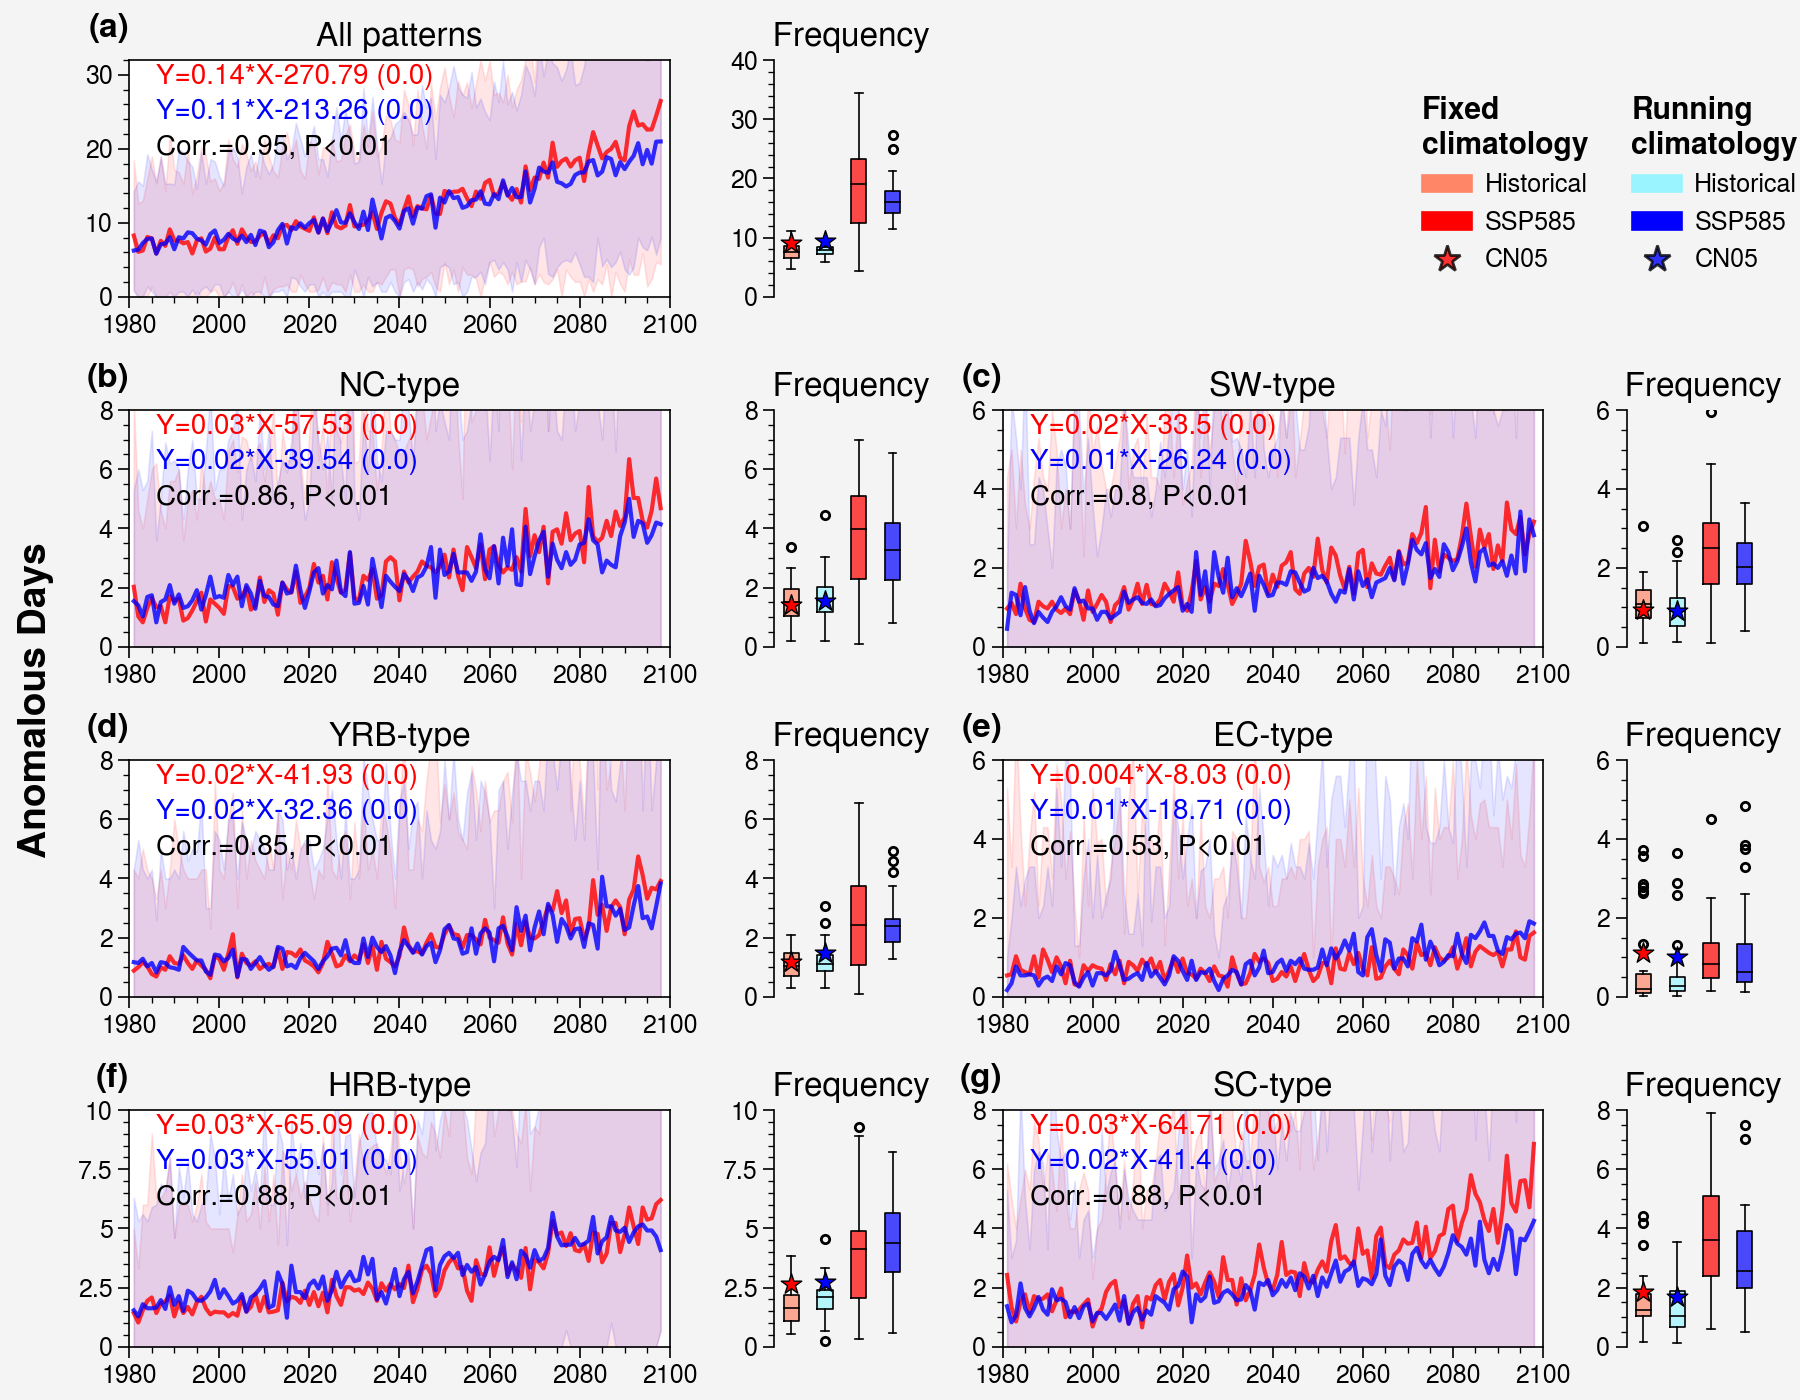

In [105]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

array = [
            [1, 1, 1, 1, 2, 0, 0, 0, 0, 0],
            [3, 3, 3, 3, 4, 5, 5, 5, 5, 6],
            [7, 7, 7, 7, 8, 9, 9, 9, 9, 10],
            [11, 11, 11, 11, 12, 13, 13, 13, 13, 14],
        ]

fig, ax = pplt.subplots(array, width = 9, height = 7, share=1)
# fig, ax = pplt.subplots(ncols=2, nrows=7, width = 6, height = 10, wratios = (9,2), share=1)

count_patterns_fixed = [
    count_patterns_all_fixed,
    count_pattern1_all_fixed,count_pattern2_all_fixed,count_pattern3_all_fixed,
    count_pattern4_all_fixed,count_pattern5_all_fixed,count_pattern6_all_fixed]
count_patterns_running = [
    count_patterns_all_running,
    count_pattern1_all_running,count_pattern2_all_running,count_pattern3_all_running,
    count_pattern4_all_running,count_pattern5_all_running,count_pattern6_all_running]

ano_prec_type = ['All patterns','NC-type','SW-type','YRB-type','EC-type','HRB-type','SC-type']

def add_panel_label(ax, label, x = 0, y = 1.2):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=12, fontweight='bold', va='top', ha='right')

for i in range(7):
    if i == 0:
        a = 0
    elif i == 1:
        a = 2
    elif i == 2:
        a = 4
    elif i == 3:
        a = 6
    elif i == 4:
        a = 8
    elif i == 5:
        a = 10
    elif i == 6:
        a = 12
    count_pattern_i_fixed = count_patterns_fixed[i]
    count_pattern_median_i_fixed = count_pattern_i_fixed.mean(axis=1)
    count_pattern_005_i_fixed = get_forcing_ens_envelope(count_pattern_i_fixed,0.05)
    count_pattern_095_i_fixed = get_forcing_ens_envelope(count_pattern_i_fixed,0.95)
    ax[a].plot(count_pattern_median_i_fixed.index, count_pattern_median_i_fixed, color='red',alpha=0.8)
    ax[a].fill_between(count_pattern_median_i_fixed.index, count_pattern_005_i_fixed, count_pattern_095_i_fixed, color='red',alpha=0.1)
    # ax[a].plot(count_pattern_obs_fixed.index,count_pattern_obs_fixed['Pattern'+str(i+1)],color='blue',alpha=0.6)#
    ax[a].set_title(ano_prec_type[i],fontsize=12)
    ax[a].set_ylabel('')
    ax[a].grid(False)

    count_pattern_i_running = count_patterns_running[i]
    count_pattern_median_i_running = count_pattern_i_running.mean(axis=1)
    count_pattern_005_i_running = get_forcing_ens_envelope(count_pattern_i_running,0.05)
    count_pattern_095_i_running = get_forcing_ens_envelope(count_pattern_i_running,0.95)
    ax[a].plot(count_pattern_median_i_running.index, count_pattern_median_i_running, color='blue',alpha=0.8)
    ax[a].fill_between(count_pattern_median_i_running.index, count_pattern_005_i_running, count_pattern_095_i_running, color='blue',alpha=0.1)
    # ax[a].plot(count_pattern_obs_running.index,count_pattern_obs_running['Pattern'+str(i+1)],color='blue',alpha=0.6)

    reg_func = np.poly1d(np.polyfit(count_pattern_median_i_running.index, count_pattern_median_i_running, 1))
    slope, intercept, _, p, _ = linregress(count_pattern_median_i_running.index, count_pattern_median_i_running)
    if intercept > 0:
        s = 'Y=' + str(round(slope,2)) + '*X+' + str(round(intercept,2)) + ' (' + str(round(p,2)) + ')'
    else:
        s = 'Y=' + str(round(slope,2)) + '*X' + str(round(intercept,2)) + ' (' + str(round(p,2)) + ')'
    ax[a].text(x = 0.05, y = 0.75, s = s, fontsize=10, color = 'blue',transform=ax[a].transAxes)

    reg_func = np.poly1d(np.polyfit(count_pattern_median_i_fixed.index, count_pattern_median_i_fixed, 1))
    slope, intercept, _, p, _ = linregress(count_pattern_median_i_fixed.index, count_pattern_median_i_fixed)
    if intercept > 0:
        s = 'Y=' + str(round(slope,2)) + '*X+' + str(round(intercept,2)) + ' (' + str(round(p,2)) + ')'
    else:
        if i == 4:
            s = 'Y=' + str(round(slope,3)) + '*X' + str(round(intercept,2)) + ' (' + str(round(p,2)) + ')'
        else:
            s = 'Y=' + str(round(slope,2)) + '*X' + str(round(intercept,2)) + ' (' + str(round(p,2)) + ')'
    ax[a].text(x = 0.05, y = 0.9, s = s, fontsize=10, color = 'red',transform=ax[a].transAxes)

    corr  = round(scipy.stats.pearsonr(count_pattern_median_i_fixed,count_pattern_median_i_running)[0],2)
    sig   = round(scipy.stats.pearsonr(count_pattern_median_i_fixed,count_pattern_median_i_running)[1],2)
    ax[a].text(x = 0.05, y = 0.6, s = 'Corr.=' + str(corr) + ', P<0.01', fontsize=10, color = 'black',transform=ax[a].transAxes)

    ax[a].set_xlim([1980,2100])
    if i == 0:
        ax[a].set_ylim([0,32])
        ax[a+1].set_ylim([0,32])
    elif i == 1:
        ax[a].set_ylim([0,8])
        ax[a+1].set_ylim([0,8])
    elif i == 2:
        ax[a].set_ylim([0,6])
        ax[a+1].set_ylim([0,6])
    elif i == 3:
        ax[a].set_ylim([0,8])
        ax[a+1].set_ylim([0,8])
    elif i == 4:
        ax[a].set_ylim([0,6])
        ax[a+1].set_ylim([0,6])
    elif i == 5:
        ax[a].set_ylim([0,10])
        ax[a+1].set_ylim([0,10])
    elif i == 6:
        ax[a].set_ylim([0,8])
        ax[a+1].set_ylim([0,8])

    total_fixed_hist = count_pattern_i_fixed.loc[1981:2015].mean(axis=0)
    total_fixed_ssp585 = count_pattern_i_fixed.loc[2061:2095].mean(axis=0)
    total_running_hist = count_pattern_i_running.loc[1981:2015].mean(axis=0)
    total_running_ssp585 = count_pattern_i_running.loc[2061:2095].mean(axis=0)

    cmap = ['#FF8767','#99F4FF','red','blue']

    total_fixed = pd.DataFrame({
        'Fixed_historical':total_fixed_hist,'Running_historical':total_running_hist,
        'Fixed_SSP585':total_fixed_ssp585,'Running_SSP585':total_running_ssp585,})
    print(ano_prec_type[i] + ' total median historical (fixed): ' + str(total_fixed_hist.median(axis=0)))
    print(ano_prec_type[i] + ' total median SSP585 (fixed):' + str(total_fixed_ssp585.median(axis=0)))
    print(ano_prec_type[i] + ' SSP585 / hist (fixed):' + str(round(total_fixed_ssp585.median(axis=0) / total_fixed_hist.median(axis=0),2)))
    print(ano_prec_type[i] + ' total median historical (running): ' + str(total_running_hist.median(axis=0)))
    print(ano_prec_type[i] + ' total median SSP585 (running):' + str(total_running_ssp585.median(axis=0)))
    print(ano_prec_type[i] + ' SSP585 / hist (running):' + str(round(total_running_ssp585.median(axis=0) / total_running_hist.median(axis=0),2)))

    ax[a+1].box(total_fixed, means=False,marker='.', meancolor='green',cycle=cmap, alpha=0.7)
    if i == 0:
        total_obs_fixed = count_pattern_obs_fixed.sum(axis=1).mean()
        total_obs_running = count_pattern_obs_running.sum(axis=1).mean()
    else:
        total_obs_fixed = count_pattern_obs_fixed['Pattern'+str(i)].mean()
        total_obs_running = count_pattern_obs_running['Pattern'+str(i)].mean()
    ax[a+1].scatter(x=0,y=total_obs_fixed,markers='*',edgecolors='black',s=60,facecolors='red',linewidth=0.5,zorder=10)
    ax[a+1].scatter(x=1,y=total_obs_running,markers='*',edgecolors='black',s=60,facecolors='blue',linewidth=0.5,zorder=10)

    ax[a+1].xaxis.set_ticks([])
    ax[a+1].set_title('  Frequency',fontsize=12)
    ax[a+1].spines['top'].set_visible(False)
    ax[a+1].spines['right'].set_visible(False)
    ax[a+1].spines['bottom'].set_visible(False)
    ax[a+1].format(facecolor='none')
    ax[a+1].grid(False)
    ax[a+1].set_ylim((ax[a+1].get_yticks()[0],ax[a+1].get_yticks()[-1]))

fig.supylabel('Anomalous Days', fontsize=14, x = 0.01)

# labels = ['Historical_fixed','Historical_running','SSP585_fixed','SSP585_running','CN05_fixed','CN05_running'] 
# legend_elements = [
#     Patch(facecolor=cmap[0], edgecolor=cmap[0],label='Historical_fixed'),
#     Patch(facecolor=cmap[1], edgecolor=cmap[1],label='Historical_running'),
#     Patch(facecolor=cmap[2], edgecolor=cmap[2],label='SSP585_fixed'),
#     Patch(facecolor=cmap[3], edgecolor=cmap[3],label='SSP585_running'),
#     Line2D([0], [0], marker='*' ,color='none',markerfacecolor='red', label='CN05_fixed',alpha=0.8,markersize=10),
#     Line2D([0], [0], marker='*' ,color='none',markerfacecolor='blue', label='CN05_running',alpha=0.8,markersize=10)]
# handles = legend_elements
# ax[1].legend(handles,labels,frameon=False,ncol=2,loc=2,bbox_to_anchor=[3.5,0.7],fontsize = 13, fancybox = False)

labels1 = ['Historical','SSP585','CN05'] 
legend_elements1 = [
    Patch(facecolor=cmap[0], edgecolor=cmap[0],label='Historical'),
    Patch(facecolor=cmap[2], edgecolor=cmap[2],label='SSP585'),
    Line2D([0], [0], marker='*' ,color='none',markerfacecolor='red', label='CN05',alpha=0.8,markersize=10)]
handles1 = legend_elements1
l1 = ax[1].legend(handles1,labels1,frameon=False,ncol=1,loc=2,bbox_to_anchor=[4.7,0.9],fontsize = 13, fancybox = False, title = 'Fixed\nclimatology')

labels2 = ['Historical','SSP585','CN05'] 
legend_elements2 = [
    Patch(facecolor=cmap[1], edgecolor=cmap[1],label='Historical'),
    Patch(facecolor=cmap[3], edgecolor=cmap[3],label='SSP585'),
    Line2D([0], [0], marker='*' ,color='none',markerfacecolor='blue', label='CN05',alpha=0.8,markersize=10)]
handles2 = legend_elements2
l2 = ax[1].legend(handles2,labels2,frameon=False,ncol=1,loc=2,bbox_to_anchor=[6.25,0.9],fontsize = 13, fancybox = False, title = 'Running\nclimatology')

ax[1].add_artist(l1)
plt.setp(l1.get_title(),fontsize='large',fontweight='bold')
plt.setp(l2.get_title(),fontsize='large',fontweight='bold')

# fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')

add_panel_label(ax[0],'(a)')
add_panel_label(ax[2],'(b)')
add_panel_label(ax[4],'(c)')
add_panel_label(ax[6],'(d)')
add_panel_label(ax[8],'(e)')
add_panel_label(ax[10],'(f)')
add_panel_label(ax[12],'(g)')

plt.tight_layout()

fig_dir = 'figure/'
fig.savefig(fig_dir + "Compare_anomalous_precipitation_CMIP6.pdf")